# MixSig
## Option 1
Create a model that reads a sequence of numbers, one number at a time, and classify that number based on all previously seen numbers.

## Option 2
Create a model that reads a sequence of numbers and classifies the last number in the sequence based on the previous numbers in the sequence.

## How this project is useful
 1. full control over dataset
 2. infinite dataset
 3. can study all three RNN base problems (classification, prediction, forcasting).
 

## Project Steps
 1. create dataset
 2. create network
 3. train network
 4. test network

## TODO
 - [x] create single signal generator class
 - [x] create mixed signal generator class
 - [ ] create signal noise functions (Gaussian, OU, etc.)
 - [ ] create timestep noise functions 
 - [x] add legends to plots.
 - [ ] during training, save outlier X, y train sets to file for further analysis.
 - [x] save configuration of mixed signal properties as json.
 - [ ] make plots of the mixed signal with colors mapped to hidden layers, lstm states, etc.
 - [ ] unit tests with pytest
 - [ ] unit tests with pytest - args
 - [ ] unit tests with pytest - kwargs
 - [ ] unit tests with pytest - random generators
 - [ ] create startup.py to handle project directories and other goodies.
 - [ ] fix savefig clipping the bottoms of our figures.

## Data generator parameters to test
 1. All 4 wave variables
  - amplitude
  - frequency (period)
  - offset
  - phase
 2. sequence length
 3. signal noise
 4. timestep noise
 5. number of signals
 

## Model hyperparameters to test
 - number of timestamps `n_timestamps`
 - number of timesteps `n_timesteps`
 - number of neurons per LSTM `n_neurons`
 - number of LSTM recurrent cells
 - number of LSTM layers
 - number of epochs
 - batch_size
 

## Questions to answer
 Q: What would a batch look like?
 
 Q: How many LSTM layers do we need? nodes per LSTM layer?
 
 Q: Can we learn if our timestamps are not uniformly spaced.
 
 Q: Should we make the LSTM layers stateful?
 
 Q: Should we use sliding window or boxcar sequences?
 
 Q: For stateful LSTM's must we `model.reset_states()` after any `model.evaluate()` and/or `model.predict()` calls? 
 
 A: **YES** Ref: Greenlee's book on LSTM's. p.49

In [1]:
import os
import sys
import json
import h5py
from datetime import datetime
import numpy as np
import pandas as pd
from pandas.plotting import table
from random import random

import matplotlib.pyplot as plt
%matplotlib inline

# from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Masking
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model


/home/maddoxw/.virtualenvs/DiscRimNN/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
import tensorflow as tf

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [ ]:
plt.rcParams['figure.dpi'] = 120

In [3]:
def highlight_column_matches(data, column='', color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_mixed = data == data[column]
        return [attr if v else '' for v in is_mixed]
    else:  # from .apply(axis=None)
        is_mixed = data == data[column]
        return pd.DataFrame(np.where(is_mixed, attr, ''), index=data.index, columns=data.columns)

def get_timestamp(t=None, format='%Y-%m-%d_%H-%M-%S'):
    """Return timestamp as a string; default: current time, format: YYYY-DD-MM_hh-mm-ss."""
    if t is None:
        t = datetime.now()
    return t.strftime(format)

def plot_stats(csv_filename, columns=['total_reward'], **kwargs):
    """Plot specified columns from CSV file."""
    df_stats = pd.read_csv(csv_filename)
    df_stats[columns].plot(**kwargs)

# Ref http://connor-johnson.com/2014/02/01/smoothing-with-exponentially-weighted-moving-averages/
def holt_winters_second_order_ewma(x, span, beta):
    N = x.size
    alpha = 2.0 / (1 + span)
    s = np.zeros((N,))
    b = np.zeros((N,))
    s[0] = x[0]
    for i in range(1, N):
        s[i] = alpha * x[i] + (1 - alpha) * (s[i-1] + b[i-1])
        b[i] = beta * (s[i] - s[i-1]) + (1 - beta) * b[i-1]
    return s

def reversed_recombined_holt_winters(x, span=15, beta=0.3):
    # take EWMA in both directions with a smaller span term
    fwd = holt_winters_second_order_ewma(x, span, beta)
    bwd = holt_winters_second_order_ewma(x[::-1], span, beta)
    c = np.vstack((fwd, bwd[::-1])) # lump fwd and bwd together
    c = np.mean(c, axis=0) # average
    return c

In [ ]:
from numpy.lib import stride_tricks

def rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return stride_tricks.as_strided(a, shape=shape, strides=strides)
Z = np.arange(10)
Z = np.arange(1,15, dtype=np.uint32)
R = rolling(Z, 4)
print(R)

print(Z)
R = stride_tricks.as_strided(Z,(11,4),(4,4))
print(R)

## Build a signal generator

The signal generator builds waves using the standard form:

$$x(t) = h + A\sin\left(\frac{2\pi t}{T} + \phi\right)$$

where $h$ is the height (vertical offset), $A$ is the amplitude (vertical scale), $T$ is the period (horizontal scale), and $\phi$ is the phase (horizontal offset). This give us fine grained control over how we construct our waves.

In [4]:
from mixsig.mixed import MixedSignal

In [7]:
# start off with simplest case for proof of concept
sig1_coeffs = {
    'amplitude': {'mean': 1.0, 'delta': 0}, 
    'offset': {'mean': -0.4, 'delta': 0}, 
    'period': {'mean': 1, 'delta': 0},
    'phase': {'mean': 0, 'delta': 0},
    'name': 'A',
    'color': '#ff0000'
}
sig2_coeffs = {
    'amplitude': {'mean': 1.0, 'delta': 0}, 
    'offset': {'mean': 0.0, 'delta': 0}, 
    'period': {'mean': 1, 'delta': 0},
    'phase': {'mean': 0, 'delta': 0},
    'name': 'B',
    'color': '#00ff00'
}
sig3_coeffs = {
    'amplitude': {'mean': 1.0, 'delta': 0}, 
    'offset': {'mean': 0.4, 'delta': 0}, 
    'period': {'mean': 1, 'delta': 0},
    'phase': {'mean': 0, 'delta': 0},
    'name': 'C',
    'color': '#0000ff'
}
sig_coeffs = {'waves': [sig1_coeffs, sig2_coeffs, sig3_coeffs]}

msig_coeffs = {
    'phase': {'mean': 0, 'delta': np.pi}, 
#     'amplitude': {'mean': 10, 'delta': 2}, 
    'period': {'mean': 20, 'delta': 0}, 
#     'offset': {'mean': 1, 'delta': 5}
}

time_coeffs = {'start': 0, 'stop': 100, 'n_timestamps': 201, 'delta': 0}

n_timesteps = 8
run_label = get_timestamp()
msig = MixedSignal(time_coeffs, sig_coeffs, msig_coeffs, n_timesteps=n_timesteps, method='sliding', run_label=run_label)
vsig = MixedSignal(time_coeffs, sig_coeffs, msig_coeffs, n_timesteps=n_timesteps, method='sliding', run_label=run_label)
msig.save_config()
X, y = msig.generate()
n_signals = msig.n_signals
print(X.shape, y.shape)

(194, 8, 1) (194, 3)


In [ ]:
# df = pd.DataFrame(np.vstack((msig.signals, msig.mixed_signal)).T, index=msig.timestamps, columns=['A', 'B', 'C', 'Mixed'])
# signals = np.array([sig() for sig in msig.signal_objects])
df = pd.DataFrame(np.vstack((msig.timestamps, msig.signals, msig.mixed_signal)).T, columns=['time', 'A', 'B', 'C', 'Mixed'])
df[:msig.n_timesteps + 4].style.apply(highlight_column_matches, column='Mixed', color='lightblue', axis=1)

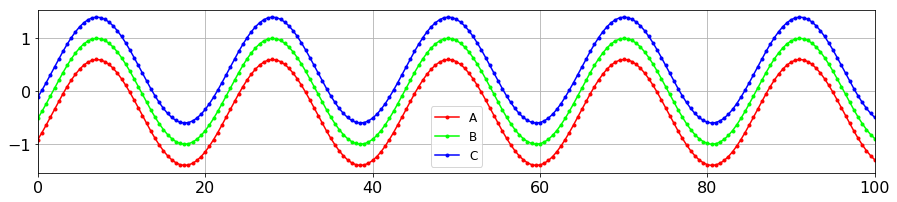

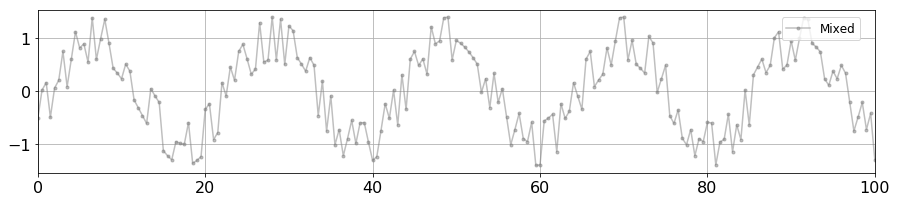

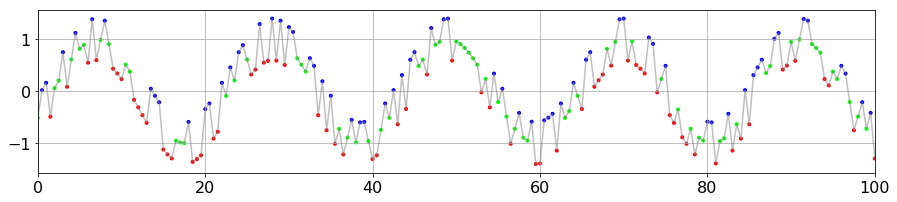

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
legend_labels = []
for i in range(msig.n_signals):
    ax.plot(msig.timestamps, msig.signals[i], marker='.', color=msig.signal_colors[i])
    legend_labels.append(msig.signal_names[i])
ax.set_xlim((msig.time_start, msig.time_stop))
plt.grid(True)
ax.legend(legend_labels)
plt.savefig(os.path.join(msig.out_dir, 'signals.png'))
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', marker='.', alpha=0.5)
# ax.scatter(msig.timestamps, msig.mixed_signal, color='grey', marker='.')
ax.set_xlim((msig.time_start, msig.time_stop))
plt.grid(True)
ax.legend([msig.name], loc='upper right', bbox_to_anchor=(0.99, 0.99))
plt.savefig(os.path.join(msig.out_dir, 'mixedsignal.png'))
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.5)
ax.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=msig.one_hots)
ax.set_xlim((msig.time_start, msig.time_stop))
plt.grid(True)
plt.savefig(os.path.join(msig.out_dir, 'mixedsignal_with_truth.png'))
plt.show()

# Playground

In [9]:
n_neurons = 10
n_layers = 1
batch_size = 1

In [10]:
def save_states(states):
    np.save(os.path.join(vsig.out_dir, 'valid_y_hat'), states['y_hat'])
    np.save(os.path.join(vsig.out_dir, 'valid_1_hidden_layer'), states['1']['hidden_layer'])
    np.save(os.path.join(vsig.out_dir, 'valid_1_cell_state'), states['1']['cell_state'])
    np.save(os.path.join(vsig.out_dir, 'valid_2_hidden_layer'), states['2']['hidden_layer'])
    np.save(os.path.join(vsig.out_dir, 'valid_2_cell_state'), states['2']['cell_state'])

In [ ]:
# define model
model = Sequential()
# model.add(Masking(mask_value=-1, input_shape=(1,)))
# model.add(LSTM(n_neurons, input_shape=(msig.n_timesteps, 1), return_sequences=True))
# model.add(LSTM(n_neurons, input_shape=self.input_shape, return_sequences=False, dropout=0.5))
# model.add(LSTM(n_neurons, input_shape=(2, 1)))
# model.add(LSTM(n_neurons, input_shape=(n_timesteps, 2)))
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, n_timesteps, 1), stateful=True, return_sequences=True))
# model.add(LSTM(n_neurons, batch_input_shape=(n_timesteps, 1, 1), stateful=True, return_sequences=True))
# model.add(LSTM(n_neurons, batch_input_shape=(n_timesteps, 1, 1), stateful=True))
# model.add(LSTM(n_neurons, return_sequences=True))
# model.add(LSTM(n_neurons))
# for _ in range(n_layers):
#     model.add(LSTM(n_neurons, stateful=True, return_sequences=True))
model.add(LSTM(n_neurons, stateful=True))
model.add(Dense(n_signals, activation='softmax'))
# model.add(Dropout(0.5))
# model.add(Reshape((n_neurons, n_signals, 1)))
# model.add(TimeDistributed(Dense(msig.n_signals, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

In [11]:
def get_model():
    
    x = Input(batch_shape=(batch_size, n_timesteps, 1))
#     z, sh1, sc1 = LSTM(n_neurons, stateful=True, return_state=True, return_sequences=True)(x)
#     z, sh2, sc2 = LSTM(n_neurons, stateful=True, return_state=True, return_sequences=True)(z)
#     z = TimeDistributed(Dense(n_signals, activation='softmax'))(z)
    z, sh1, sc1 = LSTM(n_neurons, stateful=True, return_state=True, return_sequences=True)(x)
    z, sh2, sc2 = LSTM(n_neurons, stateful=True, return_state=True)(z)
    z = Dense(n_signals, activation='softmax')(z)

    model1 = Model(inputs=[x],outputs=[z])
    model2 = Model(inputs=[x],outputs=[z, sh1, sc1, sh2, sc2])
    model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#     model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model1, model2

model, model2 = get_model()
model.summary()
model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, 8, 1)                 0         
_________________________________________________________________
lstm_1 (LSTM)                [(1, 8, 10), (1, 10), (1, 480       
_________________________________________________________________
lstm_2 (LSTM)                [(1, 10), (1, 10), (1, 10 840       
_________________________________________________________________
dense_1 (Dense)              (1, 3)                    33        
Total params: 1,353
Trainable params: 1,353
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, 8, 1)                 0         
_________________________________________________________________
lstm_1 (

In [12]:
model_config_filename = os.path.join(msig.out_dir, 'model_config.json')
model_summary_filename = os.path.join(msig.out_dir, 'model_plot.png')
with open(model_config_filename, 'w') as ofs:
    json.dump(json.loads(model.to_json()), ofs, indent=4)

plot_model(model, to_file=model_summary_filename, show_shapes=True, show_layer_names=True)

In [13]:
n_generations = 200
n_epochs = 1
validate_every = 1
save_every = 10

model_weights_filename = os.path.join(msig.out_dir, 'model_weights.h5')
training_stats_filename = os.path.join(msig.out_dir, 'training_stats.csv')
stats = {'gen': [], 'loss': [], 'acc': []}
x_val, y_val = vsig.generate()
n_subsequences = msig.n_timestamps - msig.n_timesteps + 1
h_or_c = {0: 'hidden_layer', 1: 'cell_state'}
states = {
    'y_hat': np.zeros((n_generations, n_subsequences, n_signals)),
    '1': {
        'hidden_layer': np.zeros((n_generations, n_subsequences, n_neurons)), 
        'cell_state': np.zeros((n_generations, n_subsequences, n_neurons))
    },
    '2': {
        'hidden_layer': np.zeros((n_generations, n_subsequences, n_neurons)), 
        'cell_state': np.zeros((n_generations, n_subsequences, n_neurons))
    },
}

for i in range(n_generations):
    x_train, y_train = msig.generate()
    history = model.fit(
        x_train, y_train,
        epochs=n_epochs, 
        batch_size=batch_size, 
        verbose=1, 
        shuffle=False
    )
    
    stats['gen'].append(i+1)
    stats['loss'].append(history.history['loss'][-1])
    stats['acc'].append(history.history['acc'][-1])
    model.reset_states()
    
    if i % validate_every == 0:
        # args -> h1, c1, h2, c2
        y_hat, *args = model2.predict(x_val, batch_size=batch_size)
        model2.reset_states()
        states['y_hat'][i] = y_hat
        for j, state in enumerate(args):
            layer = str((j // 2) + 1)
            hc_flag = h_or_c[j % 2]
            states[layer][hc_flag][i] = state

    if i % save_every == 0:
        model.save_weights(model_weights_filename)
        df_stats = pd.DataFrame.from_dict(stats)
        df_stats.to_csv(training_stats_filename, mode='w', index=False, header=True)
        save_states(states)

model.save_weights(model_weights_filename)
df_stats = pd.DataFrame.from_dict(stats)
df_stats.to_csv(training_stats_filename, mode='w', index=False, header=True)
save_states(states)

Epoch 1/1
194/194 [==============================] - 3s 14ms/step - loss: 1.0908 - acc: 0.3814
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 1.1090 - acc: 0.3041
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 1.0899 - acc: 0.4021
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 1.1041 - acc: 0.3402
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 1.0908 - acc: 0.3918
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 1.1112 - acc: 0.2938
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 1.0929 - acc: 0.3711
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 1.0997 - acc: 0.3660
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 1.0987 - acc: 0.3402
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 1.0954 - acc: 0.3505
Epoch 1/1
194/194 [==============================]

194/194 [==============================] - 2s 11ms/step - loss: 0.3681 - acc: 0.8351
Epoch 1/1
194/194 [==============================] - 2s 12ms/step - loss: 0.3383 - acc: 0.8763
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.2660 - acc: 0.8866
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.1703 - acc: 0.9639
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.4634 - acc: 0.8763
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.2827 - acc: 0.9278
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.2216 - acc: 0.9227
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.3429 - acc: 0.8814
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.1953 - acc: 0.9124
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.2498 - acc: 0.9124
Epoch 1/1
194/194 [==============================] - 2s 11ms

194/194 [==============================] - 2s 11ms/step - loss: 0.0176 - acc: 1.0000
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.2399 - acc: 0.9072
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.2433 - acc: 0.9278
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.3997 - acc: 0.9381
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.1417 - acc: 0.9536
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.0970 - acc: 0.9742
Epoch 1/1
194/194 [==============================] - 2s 12ms/step - loss: 0.1092 - acc: 0.9639
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.0436 - acc: 0.9948
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.1827 - acc: 0.9278
Epoch 1/1
194/194 [==============================] - 2s 11ms/step - loss: 0.2652 - acc: 0.9124
Epoch 1/1
194/194 [==============================] - 2s 12ms

In [ ]:
states['1']['hidden_layer'].shape

In [ ]:
score = model.evaluate(x_val, y_val, batch_size=batch_size)
model.reset_states()
y_hat = model.predict(x_val, batch_size=batch_size)
model.reset_states()

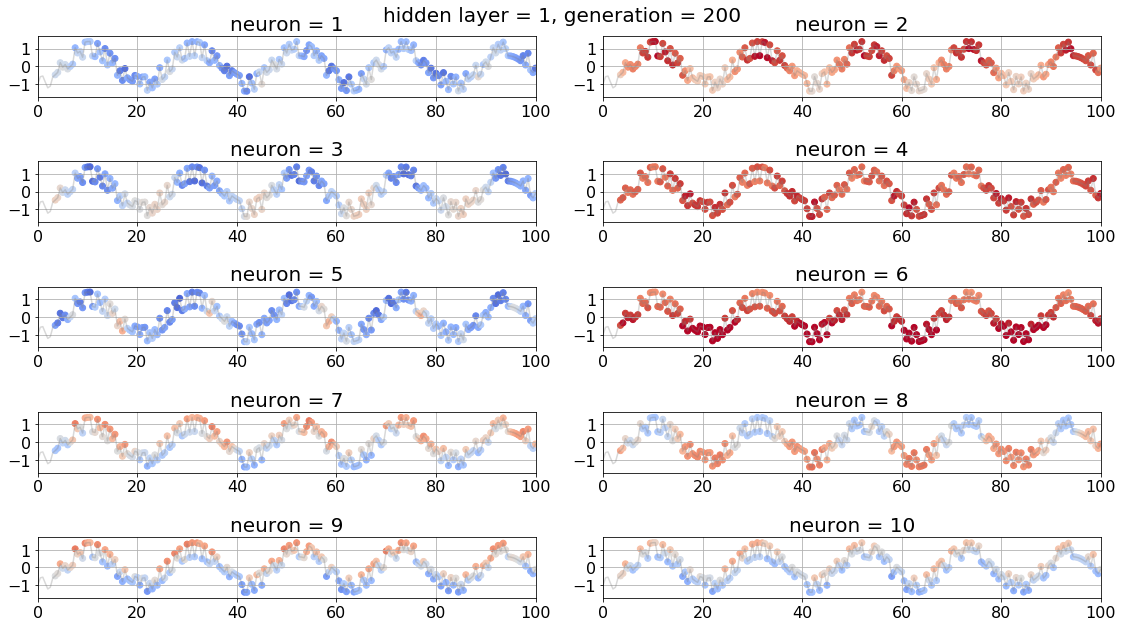

In [17]:
# y_pred = np.argmax(states['y_hat'], axis=1)
# y_pred_colors = np.hstack([vsig.signal_colors[i] for i in y_pred])

layer = '1'
h_or_c = 'hidden_layer'
val_arrays = np.load(os.path.join(vsig.out_dir, '_'.join(['valid', layer, h_or_c])) + '.npy')
n_generations, _, n_neurons = val_arrays.shape
ncols = 2
nrows = n_neurons // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 9))

for g in range(n_generations):
    for i in range(n_neurons):
        ax = axes[i // ncols, i % ncols]
        ax.cla()
        y_pred_colors = val_arrays[g, :, i]
        ax.plot(vsig.timestamps, vsig.mixed_signal, color='grey', alpha=0.3)
        ax.scatter(
            vsig.timestamps[vsig.n_timesteps-1:], 
            x_val[:, -1, 0], 
            marker='o', 
            c=y_pred_colors, 
            cmap=plt.get_cmap('coolwarm'), 
            vmin=-1, 
            vmax=1
        )
        ax.set_title('neuron = {}'.format(i + 1))
        ax.set_xlim((vsig.time_start, vsig.time_stop))
        ax.grid(True)
    plt.tight_layout()
    plt.suptitle('hidden layer = {}, generation = {}'.format(layer, g + 1))
    plt.savefig(os.path.join(vsig.out_dir, '_'.join(['valid', layer, h_or_c, 'gen', str(g + 1)]) + '.png'))
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].plot(df_stats.loss)
# ax[0].plot(df_stats.loss, color='grey', alpha=0.3)
# hw_loss = reversed_recombined_holt_winters(np.array(df_stats.loss))
# ax[0].plot(hw_loss)
ax[0].set_title(r'n_timestamps = {}, n_timesteps = {}'.format(msig.n_timestamps, msig.n_timesteps))
ax[0].set_xlabel(r'generation')
ax[0].set_xlim((0, n_generations))
ax[0].set_ylabel(r'loss')
ax[0].set_ylim((0, None))
ax[0].grid(True)

ax[1].plot(df_stats.acc)
# ax[1].plot(df_stats.acc, color='grey', alpha=0.3)
# hw_acc = reversed_recombined_holt_winters(np.array(df_stats.acc))
# ax[1].plot(hw_acc)
ax[1].set_title(r'n_neurons = {}, batch_size = {}'.format(n_neurons, batch_size))
ax[1].set_xlabel(r'generation')
ax[1].set_xlim((0, n_generations))
ax[1].set_ylabel(r'accuracy')
ax[1].set_ylim((0, 1))
ax[1].grid(True)
plt.savefig(os.path.join(msig.out_dir, 'loss_acc.png'))
plt.tight_layout()
plt.show()

In [ ]:
x_test, y_test = msig.generate()
y_hat, *args = model2.predict(x_test, batch_size=batch_size)
model2.reset_states()
y_pred = np.argmax(y_hat, axis=1)

In [ ]:
print(y_hat.shape, args[0].shape, args[1].shape, args[2].shape, args[3].shape)
print(np.min(y_hat), np.min(args[0]), np.min(args[1]), np.min(args[2]), np.min(args[3]))
print(np.max(y_hat), np.max(args[0]), np.max(args[1]), np.max(args[2]), np.max(args[3]))


In [ ]:
y_pred_colors = np.hstack([args[2][i, 0] for i in y_pred])
print(y_pred.shape, y_pred_colors.shape)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
ax.scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_pred_colors)
ax.set_xlabel('time')
ax.set_xlim((msig.time_start, msig.time_stop))
plt.grid(True)
plt.show()

In [ ]:
x_test, y_test = msig.generate()
score = model.evaluate(x_test, y_test, batch_size=batch_size)
model.reset_states()
y_hat = model.predict(x_test, batch_size=batch_size)
model.reset_states()
y_pred = np.argmax(y_hat, axis=1)
# y_pred = model.predict_classes(x_test, batch_size=batch_size)
# y_pred_colors = [msig.signal_objects[i].color for i in msig.classes[msig.n_timesteps-1:]]
y_pred_colors = np.hstack([msig.signal_colors[i] for i in y_pred])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
ax.scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_pred_colors)
ax.set_title('loss = {:<6.4f}, accuracy = {:<6.4f}'.format(*score))
ax.set_xlabel('time')
ax.set_xlim((msig.time_start, msig.time_stop))
plt.grid(True)
plt.savefig(os.path.join(msig.out_dir, 'eval_pred.png'))
plt.show()

In [ ]:
model.

In [ ]:
x_test, y_test = msig.generate()
print(x_test.shape)
print(y_test.shape)

score = model.evaluate(x_test, y_test, batch_size=batch_size)
model.reset_states()
print(score)

y_pred = model.predict_classes(x_test, batch_size=batch_size)
# y_hat = model.predict(x_test, batch_size=batch_size)
# y_pred = np.argmax(y_hat, axis=1)
# y_error = 1.0 - np.max(y_hat, axis=1)
model.reset_states()
# print(y_hat.shape)
print(y_pred.shape)
# print(y_error.shape)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

ax[0].plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
ax[0].scatter(msig.timestamps, msig.mixed_signal, marker='.')
ax[0].set_title('loss = {:<6.4f}, accuracy = {:<6.4f}'.format(*score))
ax[0].set_xlim((msig.time_start, msig.time_stop))

ax[1].plot(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
ax[1].scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_pred)
ax[1].set_xlim((msig.time_start, msig.time_stop))
ax[1].set_xlabel('time')
plt.show()

In [ ]:
n_batch = 1
print(X.shape)
print(n_batch)
# re-define model
new_model = Sequential()
new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
new_model.add(LSTM(n_neurons))
new_model.add(Dense(msig.n_signals, activation='softmax'))
# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)
new_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

x_test, y_test = msig.generate()
score = new_model.evaluate(x_test, y_test, batch_size=n_batch)
print(score)

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
plt.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=msig.one_hots)
plt.show()

In [ ]:
y_hat = new_model.predict(x_test, batch_size=msig.n_samples)
for i in range(len(x_test)):
    print('Expected', y_test[i], 'Predicted', y_hat[i])

In [ ]:
x_test, y_test = msig()
print(x_test.shape)
print(y_test.shape)
y_hat = new_model.predict(x_test, batch_size=msig.n_samples)
print(y_hat.shape)
y_pred = np.argmax(y_hat, axis=1)
print(y_pred.shape)
y_error = np.max(y_hat, axis=1)
print(y_error.shape)

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_pred)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_error)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[-msig.n_samples:], y_error, color='grey', alpha=0.3)
plt.scatter(msig.timestamps[-msig.n_samples:], y_error, marker='.', c=y_error)
plt.show()